In [1]:
import yaml
import model
import mnist1d
import numpy as np
import visualizations as vis
from torchvision import datasets, transforms

np.random.seed(42)

##### **How to use this notebook**:

In the configuration you can set:
- Dataset (MNIST1D, MNIST, or CIFAR10)
- Hidden dimensions (number of hidden units per layer; depth is set to 3)
- Number of epochs
- What corruptions to apply (shuffled labels, shuffled pixel, random pixel, gaussian noise, original data + gaussian noise)  

**Some tips**:

- MNIST1D trains quickly but isn't as visually intuitive
- MNIST and CIFAR10 offer clearer visualization, but take longer to train
- When using MNIST or CIFAR10, choose fewer corruptions to get results in a reasonable time

### Load configuration

In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

name_dataset = config['dataset']
hidden_dimensions = config['model'].get('hidden_dimensions')
output_dimensions = 10
epochs = config['training'].get('epochs')

### Load data

- Load the data either from the repository or use standard datasets hardcoded into the torchvision library
- Set the input dimention according to the dataset
- Convert the data to the type numpy.ndarray so that all the datasets can later be transformed by the same functions
- For MNIST and CIFAR10: flatten the pictures for easier transformations (that's also the shape that is needed to feed the data to the network later) and normalize

In [3]:
# Loads the data (specified in the configuration)
if name_dataset == "MNIST1D":
    input_dimensions = 40
        
    args = mnist1d.get_dataset_args()
    data = mnist1d.get_dataset(args, path='./data/mnist1d_data.pkl')

    # All the data is already of the type numpy.ndarray
    x_train = data['x']
    y_train = data['y']
    x_test = data['x_test']
    y_test = data['y_test']
        
elif name_dataset == "MNIST":
    input_dimensions = 784

    train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # converts all the data to the type numpy.ndarray
    x_train = train.data.numpy()
    y_train = train.targets.numpy()
    x_test = test.data.numpy()
    y_test = test.targets.numpy()

    x_train = x_train.reshape(-1, 28*28) / 255.0
    x_test = x_test.reshape(-1, 28*28) / 255.0

elif name_dataset == "CIFAR10":
    input_dimensions = 3072
    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # converts all the data to the type numpy.ndarray
    x_train = train.data
    y_train = np.array(train.targets)
    x_test = test.data
    y_test = np.array(test.targets)

    x_train = x_train.reshape(-1, 32*32*3) / 255.0
    x_test = x_test.reshape(-1, 32*32*3) / 255.0

else:
    raise ValueError("Invalid dataset name")

### Corrupt data

**Generate the corruptions** (all specified in the configuration) and store them as seperate datasets.

All possible corruptions:

- Shuffled label:
    - Shuffles all the instances in the training label dataset
    - Assigns a random label to every example in the training dataset
    - Doesn't change the distribution since no new labels are generated

- Shuffled pixel:
    - Shuffles all the pixel in every example in the training dataset
    - Distribution within the example remains the same, only changes order of pixels
    - The labels also stay the same

- Random pixel:
    - Assigns random pixels
    - Creates a completely new distribution
    - The labels stay the same
    - Examples only consist of noise
    - Destroys any underlying structure

- Gaussian noise:
    - Assigns new pixels based on the gaussian distribution of the original (for general: distribution of the entire dataset; for individual: distribution of each individual image)
    - Statistically keeps the distribution intact
    - The labels stay the same

- Original data + gaussian noise:
    - Keeps the orinal examples but adds noise on top
    - The labels stay the same
    - Keeps the underlying structure somewhat intact

In [4]:
# Corrupts the data and stores them as seperate datasets (all corruptions are specified in the configuration)
datasets = [('true labels', x_train, y_train)]

if config['corruptions'].get('shuffled_label') == 'y':
    # Create dataset with shuffle the labels
    y_train_shuffled = np.random.permutation(y_train)
    datasets.append(('shuffled labels', x_train, y_train_shuffled))
elif config['corruptions'].get('shuffled_label') != 'n':
    raise ValueError("Invalid input")


if config['corruptions'].get('shuffled_pixel') == 'y':
    # Create dataset with shuffled the pixels for each picture
    x_shuffled = np.copy(x_train)
    for i in range(x_shuffled.shape[0]):
        if name_dataset == "CIFAR10":
            x_shuffled = x_shuffled.reshape(-1,3)
        np.random.shuffle(x_shuffled[i])
    if name_dataset == "CIFAR10":
        x_shuffled = x_shuffled.reshape(-1,32*32*3)
    datasets.append(('shuffled pixels', x_shuffled, y_train))
elif config['corruptions'].get('shuffled_pixel') != 'n':
    raise ValueError("Invalid input")


if config['corruptions'].get('random_pixel') == 'y':
    # Create dataset with random pixels
    x_random = np.random.rand(*x_train.shape)
    datasets.append(('random pixels', x_random, y_train))
elif config['corruptions'].get('random_pixel') != 'n':
    raise ValueError("Invalid input")


if config['corruptions'].get('gaussian_noise_general') == 'y':
    # Create dataset with gaussian noise based on the overall distribution
    gaussian_noise_general = np.random.normal(loc=np.mean(x_train), scale=np.std(x_train), size=x_train.shape)
    datasets.append(('gaussian noise_general', gaussian_noise_general, y_train)) 
elif config['corruptions'].get('gaussian_noise_general') != 'n':
    raise ValueError("Invalid input")

if config['corruptions'].get('gaussian_noise_individual') == 'y':
    # Create dataset with gaussian noise based on the distribution of each individual image
    gaussian_noise_individual = []
    for img in x_train:
        noise_img = np.random.normal(loc=np.mean(img), scale=np.std(img), size=img.shape)
        gaussian_noise_individual.append(noise_img)
    gaussian_noise_individual = np.array(gaussian_noise_individual)
    datasets.append(('gaussian noise_individual', gaussian_noise_individual, y_train)) 
elif config['corruptions'].get('gaussian_noise_individual') != 'n':
    raise ValueError("Invalid input")


if config['corruptions'].get('original_data_plus_gaussian_noise') == 'y':
    #Create dataset with gaussian noise on top of the original data
    gaussian_noise = np.random.normal(loc=np.mean(x_train), scale=np.std(x_train), size=x_train.shape)
    x_train_noisy = x_train + gaussian_noise
    datasets.append(('true data + gaussian noise', x_train_noisy, y_train))
elif config['corruptions'].get('original_data_plus_gaussian_noise') != 'n':
    raise ValueError("Invalid input")

### Visualize Data

**Visualize the training data** (original and all the corrupted versions) to get a more intuitive understanding on how the corruptions differ from the original.

Works especially well for MNIST and CIFAR10, not so much for MNIST1D

Notes on MNIST-1D:
- The MNIST-1D dataset was designed specifically to minimalisitc (so it would need little memory and computational power)
- There are 4000 training and 1000 test samples in the dataset
- Every sample has 40 data points (we refer to them as pixels throughout this notebook)
- We couldn't find an intuitive visual representation
- It was created by 10 one-dimentional patterns that were then subjected to various transformations like padding, rotations, scaling or the addition of noise (you can find more information on how the dataset was constructed in the paper 'Scaling Down Deep Learning with MNIST-1D' by S. Greydanus and D. Kobak)
- You can see some patterns: the plots include 3 samples labeled as 6 and there is some resemblance between those. Maybe more importantly, you can see a difference to for example the sample labeled 5.
- The goal in using MNIST-1D is to get fast results in training not so much understanding the transformations (for that MNIST is better suited) 

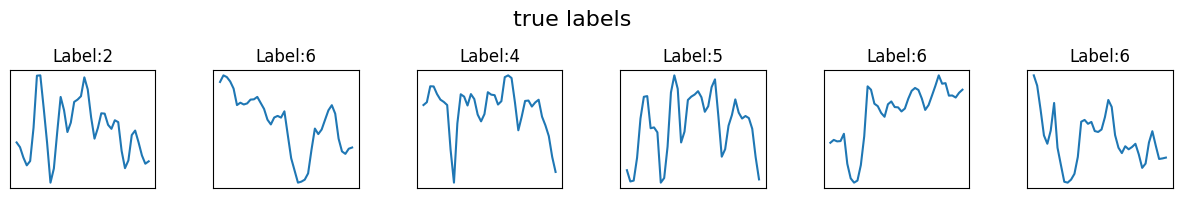

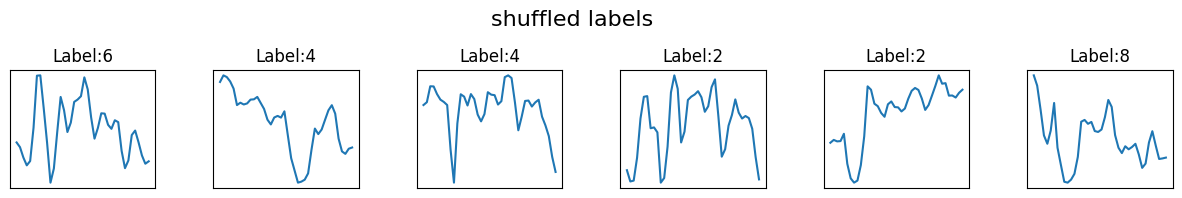

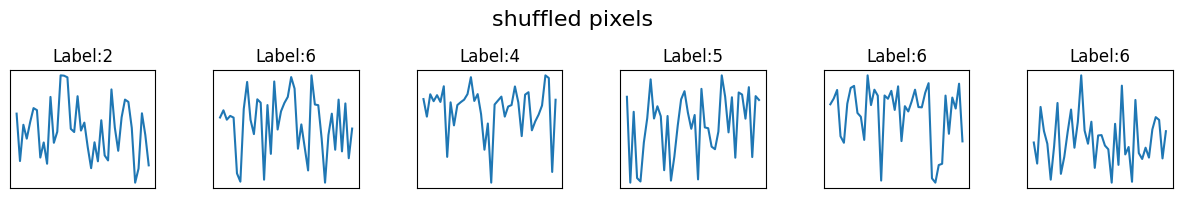

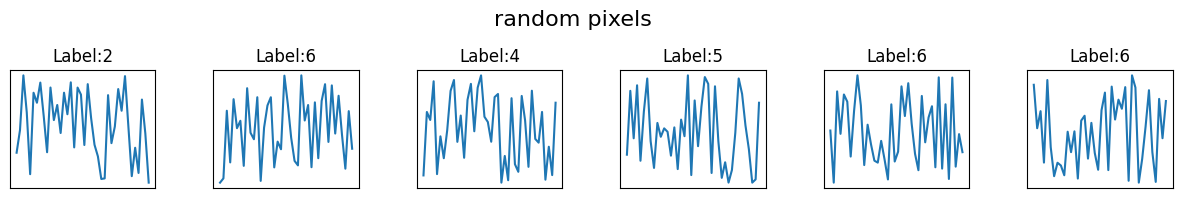

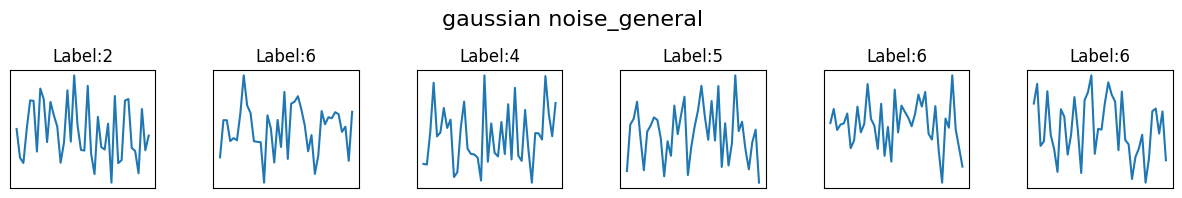

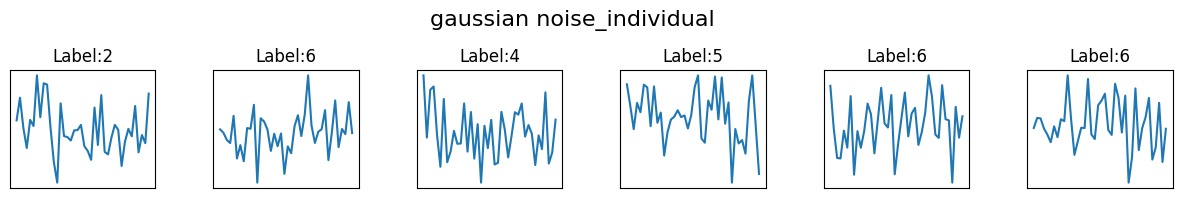

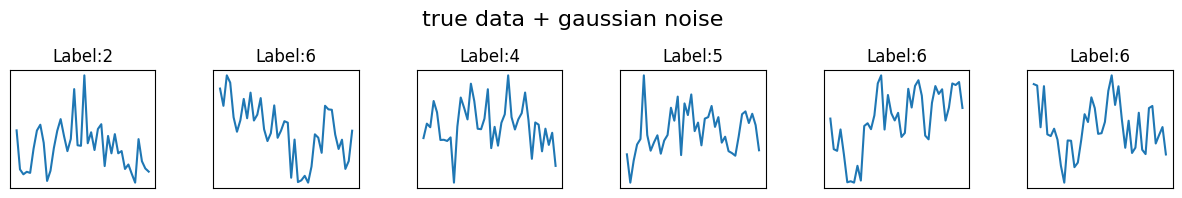

In [5]:
# Visualize data samples for each of the datasets (original and all the corrupted datasets)
for x in datasets:
    vis.visualize_data(x[1], x[2], name_dataset, True, x[0])

### Run the training of the model

**Train seperate models** on all the datasets respectively and store for every training epoch:
- Loss on training data
- Loss on test data 
- Accuracy on training data
- Accuracy on test data 

In [6]:
# Lists to store training and test results
losses = []
accuracies = []

# Train model on each dataset and collect results
for x in datasets:
    loss_train, acc_train, loss_test, acc_test = model.train_model(input_dimensions, hidden_dimensions, output_dimensions, x[0], x[1], x[2], x_test, y_test, epochs)
    losses.append((f'{x[0]}', loss_train, loss_test))
    accuracies.append((f'{x[0]}', acc_train, acc_test))

'Dataset: true data + gaussian noise, Epoch 25: Train loss = 0.0019, Train accuracy = 1.0000, Test loss = 2.5192, Test accuracy = 0.3860'

### Visualize results

**Visualize the results of the training**  
Plot loss and accuracy on both training and test data.

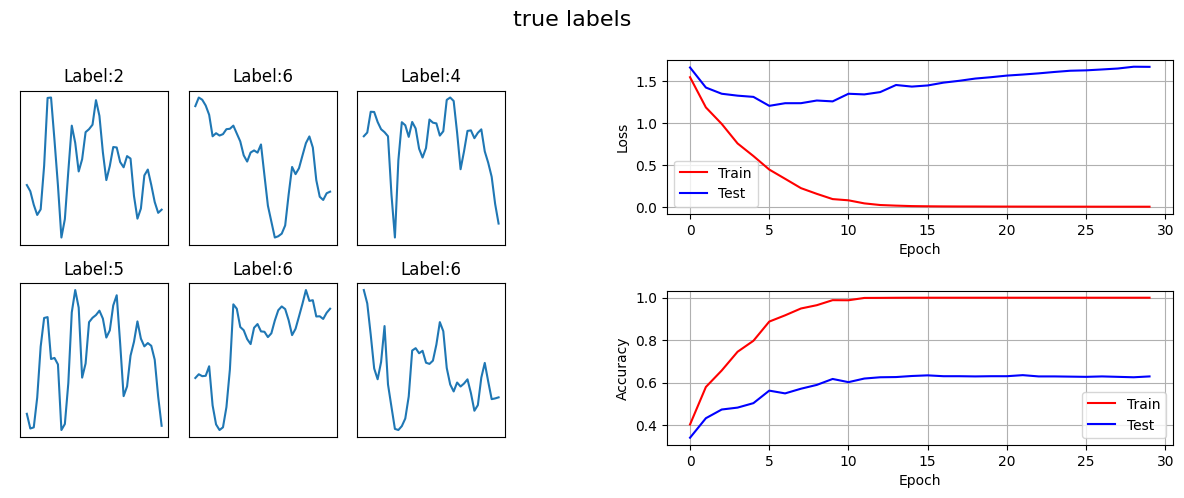

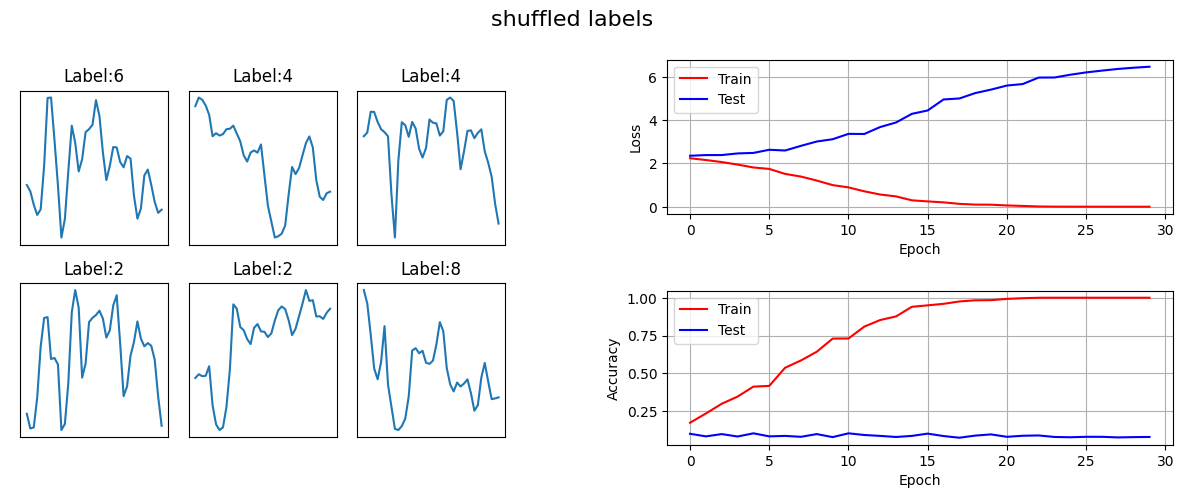

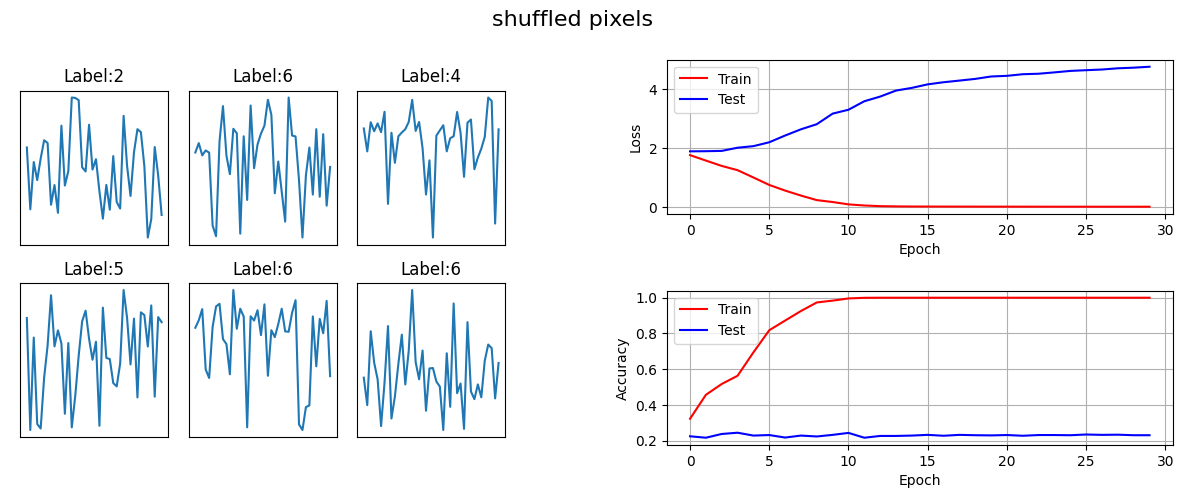

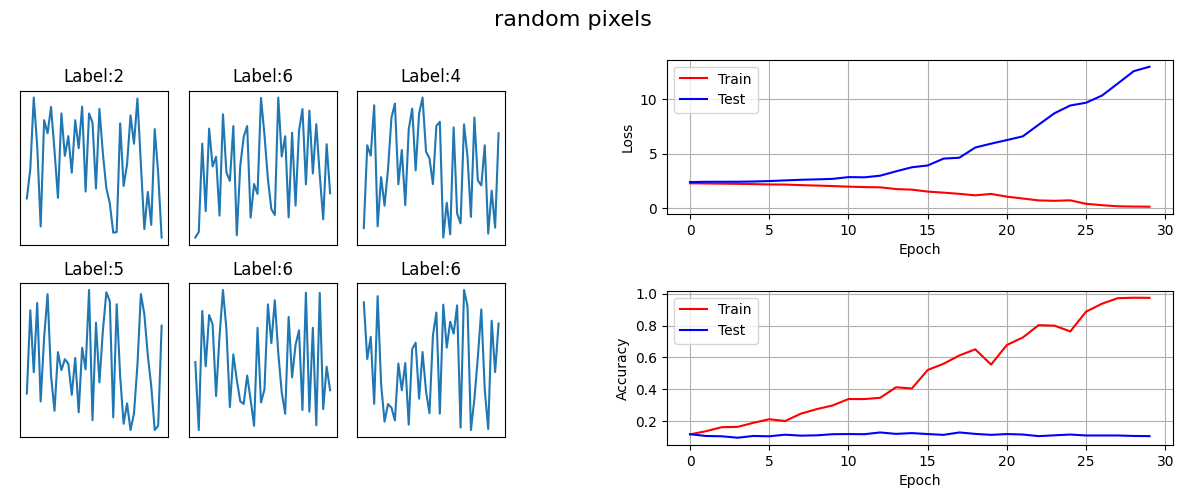

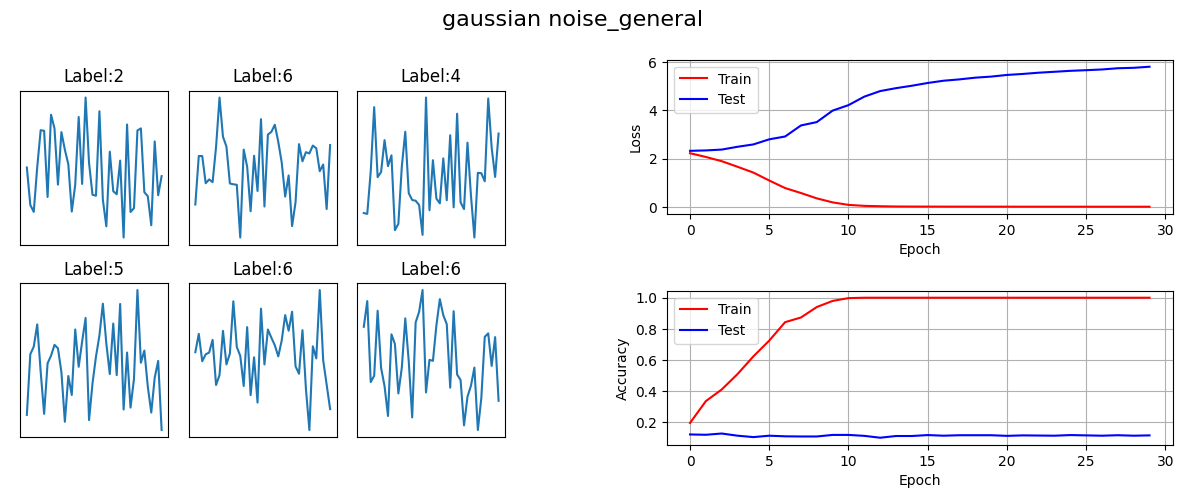

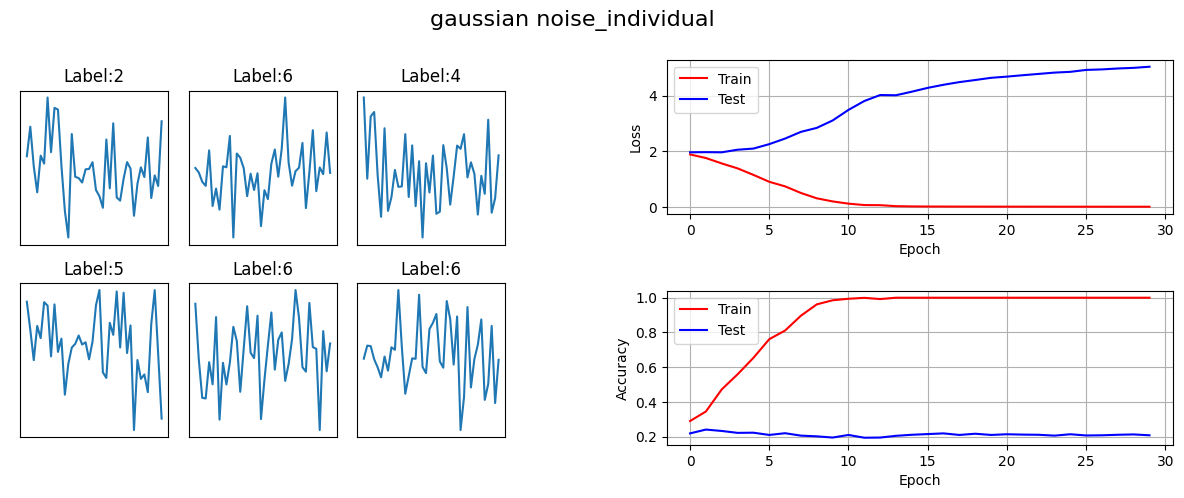

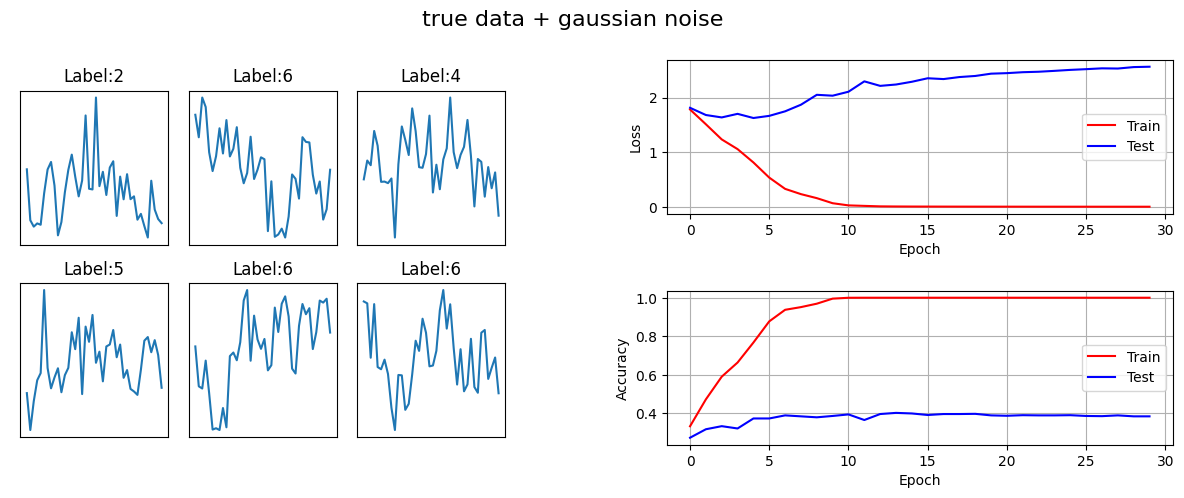

In [7]:
# Visualize summary for each dataset
for x in range(len(datasets)):
    vis.summary(datasets[x][0], datasets[x][1], datasets[x][2], name_dataset, losses[x][1], accuracies[x][1], losses[x][2], accuracies[x][2])

What you should see:  

- Loss on training decreases for all the models
- Accuracy on training increases for all the models
- For the original data: loss and accuracy also improve on test data
- For the rest: loss and accuracy improve only slightly or not at all for test data

What this means: 
- Corrupting the data and removing underlying structures hinders generalization
- BUT the model still learns to fit the training data well after sufficiently many itterations
- So, if there is no function to learn, the model will just memorize the training data to achieve 0 training loss

**Compare the different variants to each other**  
Plot all the losses in one figure and all the accuracies in another

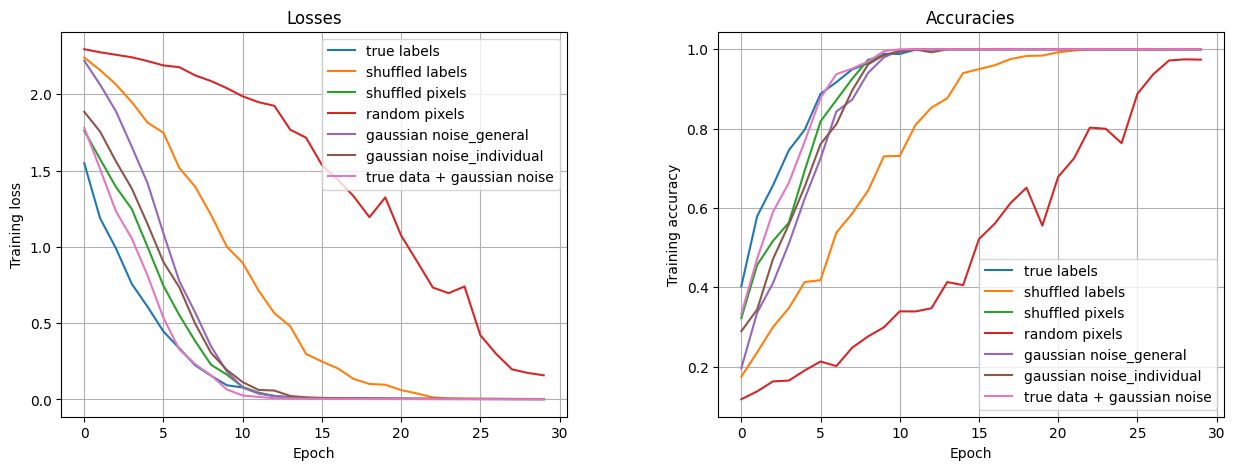

In [8]:
# Create summary statistics plots
vis.summary_statistics(losses, accuracies)

What you should see:

- The model training on the original data trains the fastest
- Nontheless the other models still improve (on predicting the training data) but do take longer